In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.nn import CrossEntropyLoss
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torchinfo import summary

from os.path import exists

from util import test_loss

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cpu


In [3]:
batch_size = 100

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=True,
                                        download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=False,
                                       download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


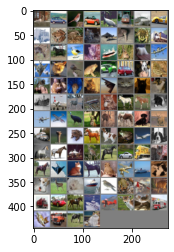

cat   car   bird  car   bird  car   ship  car   truck frog  bird  cat   plane bird  frog  truck deer  horse bird  cat   ship  deer  dog   plane plane cat   bird  frog  car   car   dog   bird  bird  cat   cat   cat   plane cat   cat   dog   ship  plane deer  plane cat   horse horse dog   plane plane bird  deer  deer  horse dog   deer  truck bird  frog  horse dog   frog  plane dog   horse horse plane bird  horse car   truck cat   horse plane cat   horse frog  plane ship  cat   dog   deer  dog   ship  bird  frog  plane deer  truck car   horse ship  plane deer  cat   truck cat   truck horse cat  


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
from Models import Cifar10_Net

input_shape = (100, 3, 32, 32)
num_labels = 10
expansion_rate = 3

NN_cif = Cifar10_Net(input_shape, num_labels, expansion_rate, device)

summary(NN_cif, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
Cifar10_Net                              [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 32, 26, 26]         4,736
│    └─CSC_block: 2-2                    [100, 64, 26, 26]         --
│    │    └─Sequential: 3-1              --                        19,520
│    └─CSC_block: 2-3                    [100, 128, 26, 26]        --
│    │    └─Sequential: 3-2              --                        75,904
│    └─AvgPool2d: 2-4                    [100, 128, 3, 3]          --
│    └─Flatten: 2-5                      [100, 1152]               --
│    └─Linear: 2-6                       [100, 64]                 73,792
│    └─ReLU: 2-7                         [100, 64]                 --
│    └─Linear: 2-8                       [100, 10]                 650
Total params: 174,602
Trainable params: 174,602
Non-trainable params:

In [6]:
PATH = "models/Cifar/Cifar10.pth"

if exists(PATH):
    NN_cif.load_state_dict(torch.load(PATH))
    NN_cif.eval()

In [7]:
criterion = CrossEntropyLoss()
optimizer_Cifar = optim.SGD(NN_cif.parameters(), lr=0.05, momentum=0.9)
scheduler_Cifar = optim.lr_scheduler.ExponentialLR(optimizer_Cifar, gamma=0.9)

In [9]:
%%timeit
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer_Cifar.zero_grad()

        # forward + backward + optimize
        outputs = NN_cif(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_Cifar.step()

        # print statistics
        running_loss += loss.item()
        if i % 250 == 249:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] train_loss: {running_loss / 100:.3f}')
            running_loss = 0.0
            print(test_loss(NN_cif, test_dataloader, criterion, device))

    scheduler_Cifar.step()

[1,   244] train_loss: 4.071
(1.4727221763134002, 47.23)


In [10]:
torch.save(NN_cif.state_dict(), "./models/Cifar/Cifar10.pth")

In [8]:
from Models import Cifar10_Net

criterion = CrossEntropyLoss()


input_shape = (100, 3, 32, 32)
num_labels = 10
expansion_rate = 3

NN2_cif = Cifar10_Net(input_shape, num_labels, expansion_rate)


PATH = "models/Cifar/Cifar10.pth"

if exists(PATH):
    NN2_cif.load_state_dict(torch.load(PATH))
    NN2_cif.eval()

print(test_loss(NN2_cif, test_dataloader, criterion))

(1.413678903579712, 49.93)
